# Regression problem with Deep Learning (Keras)


In this task, we are going to have a competition between NN and CNN, in order to check which type of network can predict the house of a price in a better way, based on some relevant parameters.

At a high-level, neural networks are either encoders, decoders, or a combination of both. Encoders find patterns in raw data to form compact, useful representations. Decoders generate new data or high-resolution useful infomation from those representations. 

As a reminder, **Feed Forward Neural Networks (FFNNs)** is a network which its goal is to work on classification and regression problems, based on features (X->Y mapping, supervised problem). See the [aspect](#Part-1:-Boston-Housing-Price-Prediction-with-Feed-Forward-Neural-Networks) of this notebook for an example.

## Part 0: Prerequisites:


[tf.keras](https://www.tensorflow.org/guide/keras) is the simplest way to build and train neural network models in TensorFlow (w/ Keras).

Note that there's [tf.keras](https://www.tensorflow.org/guide/keras) (comes with TensorFlow) and there's [Keras](https://keras.io/) (standalone). You should be using [tf.keras](https://www.tensorflow.org/guide/keras) because (1) it comes with TensorFlow so you don't need to install anything extra and (2) it comes with powerful TensorFlow-specific features.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

print(tf.__version__)

2022-03-13 18:31:06.184849: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-13 18:31:06.184896: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.7.0


## Part 1: Boston Housing Price Prediction with Feed Forward Neural Networks

Let's start with using a fully-connected neural network to do predict housing prices. The following image highlights the difference between regression and classification (see part 2). Given an observation as input, **regression** outputs a continuous value (e.g., exact temperature) and classificaiton outputs a class/category that the observation belongs to.

<img src="https://i.imgur.com/vvSoAzg.jpg" alt="classification_regression" width="400"/>

For the Boston housing dataset, we get 506 rows of data, with 13 features in each. Our task is to build a regression model that takes these 13 features as input and output a single value prediction of the "median value of owner-occupied homes (in thousands of USD)."

Now, we load the dataset. Loading the dataset returns four NumPy arrays:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

In [2]:
(train_features, train_labels), (test_features, test_labels) = keras.datasets.boston_housing.load_data()

# get per-feature statistics (mean, standard deviation) from the training set to normalize by
train_mean = np.mean(train_features, axis=0)
train_std = np.std(train_features, axis=0)
train_features = (train_features - train_mean) / train_std
print("Train dataset size: X: ", train_features.shape)
print("Train dataset size: y: ", train_labels.shape)

print("Test dataset size: X: ", test_features.shape)
print("Test dataset size: y: ", test_labels.shape)

Train dataset size: X:  (404, 13)
Train dataset size: y:  (404,)
Test dataset size: X:  (102, 13)
Test dataset size: y:  (102,)


In [3]:
# Reminder: For Conv1D CNN we shall reshape our dataset. 
# Thus, we'll have a function which will do it automatically for us as we need to do it more than once (train, test)

def reshape_for_conv1d_dataset(dataset, input_dim=1, dataset_name='train'):    
    print(f"Going to work on data: {dataset_name}")
    print("original shape of data is:", dataset.shape)

    sample_size = dataset.shape[0] # number of samples in data set
    num_features  = dataset.shape[1] # number of features in data set
    input_dimension = input_dim    # each feature is represented by input_dim number

    data_reshaped = dataset.reshape(sample_size,num_features,input_dimension)
    print(f"After reshape {dataset_name} data set shape:\n", data_reshaped.shape)
    print("1 Sample shape:\n",data_reshaped[0].shape)
    print("An example sample:\n", data_reshaped[0])
    
    return data_reshaped
#     test_data_reshaped = test_data.reshape(test_data.shape[0],test_data.shape[1],1)
# 102, 13, 1
# print(test_data_reshaped.shape)

In [4]:
train_data_reshaped = reshape_for_conv1d_dataset(train_features)
print("******")
test_data_reshaped = reshape_for_conv1d_dataset(test_features, dataset_name='test')

Going to work on data: train
original shape of data is: (404, 13)
After reshape train data set shape:
 (404, 13, 1)
1 Sample shape:
 (13, 1)
An example sample:
 [[-0.27224633]
 [-0.48361547]
 [-0.43576161]
 [-0.25683275]
 [-0.1652266 ]
 [-0.1764426 ]
 [ 0.81306188]
 [ 0.1166983 ]
 [-0.62624905]
 [-0.59517003]
 [ 1.14850044]
 [ 0.44807713]
 [ 0.8252202 ]]
******
Going to work on data: test
original shape of data is: (102, 13)
After reshape test data set shape:
 (102, 13, 1)
1 Sample shape:
 (13, 1)
An example sample:
 [[ 18.0846]
 [  0.    ]
 [ 18.1   ]
 [  0.    ]
 [  0.679 ]
 [  6.434 ]
 [100.    ]
 [  1.8347]
 [ 24.    ]
 [666.    ]
 [ 20.2   ]
 [ 27.25  ]
 [ 29.05  ]]


### Build the model

Building the neural network requires configuring the layers of the model, then compiling the model. First we stack a few layers together using `keras.Sequential`. <br>
Next we configure the loss function, optimizer, and metrics to monitor. These are added during the model's compile step:

* *Loss function* - measures how accurate the model is during training, we want to minimize this with the optimizer.
* *Optimizer* - how the model is updated based on the data it sees and its loss function.
* *Metrics* - used to monitor the training and testing steps.

Your goal is to build a network that is getting input as the input size, has 3 hidden layers (each one with a different size), and one output layer (as we want to have 1 number at the end).
Also, loss function should be: mse (mean squared error), optimizer should be Adam, and we should use mae + mse as our metrics.

In [5]:
def build_model():
    model = keras.Sequential([
        Dense(20, activation=tf.nn.relu, input_shape=[len(train_features[0])]),
        Dense(20, activation=tf.nn.relu, input_shape=[20]),
        Dense(20, activation=tf.nn.relu, input_shape=[20]),
        Dense(1)
    ])

    model.compile(optimizer=tf.optimizers.Adam(), 
                  loss='mse',
                  metrics=['mae', 'mse'])
    return model

def build_cnn_model():
    row_size = train_data_reshaped.shape[1] #13
    col_size = train_data_reshaped.shape[2] #1
    model = keras.Sequential(name='model_conv1D')
    model.add(keras.layers.Input(shape=(row_size,col_size))) # We want to make sure the model knows our input
    model.add(keras.layers.Conv1D(filters=64, kernel_size=7, activation='relu', name="Conv1D_1")) # Conv1D
    model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv1D_2")) # Conv1D
    model.add(keras.layers.Conv1D(filters=16, kernel_size=2, activation='relu', name="Conv1D_3")) # Conv1D
    model.add(keras.layers.MaxPooling1D(pool_size=2, name="MaxPooling1D")) #MaxPooling1D
    model.add(keras.layers.Flatten()) #Flatten
    model.add(keras.layers.Dense(32, activation='relu', name="Dense_1")) #Dense FC layer
    model.add(keras.layers.Dense(col_size, name="Dense_2")) # we want 1 output
    model.compile(optimizer=tf.optimizers.Adam(), 
                  loss='mse',
                  metrics=['mae', 'mse'])
    return model

### Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model—in this example, the `train_features` and `train_labels` arrays.
2. The model learns to associate features and labels.
3. We ask the model to make predictions about a test set—in this example, the `test_features` array. We verify that the predictions match the labels from the `test_labels` array. 

To start training,  call the `model.fit` method—the model is "fit" to the training data:

In [6]:
# Here and above you have a full example of a NN model performance plotting
# You should replicate this mechanism and apply it to other models as well (see TODO below)
# this helps makes our output less verbose but still shows progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

# model instantiation        
model = build_model()

# TODO: Read about EarlyStoppingRound!
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# training the model and storing data into history
history = model.fit(train_features, train_labels, epochs=1000, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])

# using Pandas, generating data
hist = pd.DataFrame(history.history)
# Adding a column called epoch to that DataFrame
hist['epoch'] = history.epoch

# RMSE 
rmse_final = np.sqrt(float(hist['val_mse'].tail(1)))
print()
print('Final Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))

2022-03-13 18:31:09.406861: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-13 18:31:09.406910: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-13 18:31:09.406932: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (driver): /proc/driver/nvidia/version does not exist
2022-03-13 18:31:09.408016: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



....................................................................................................
..............................................................................
Final Mean Square Error on validation set: 2.781


Now, let's plot the loss function measure on the training and validation sets. The validation set is used to prevent overfitting ([learn more about it here](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)). However, because our network is small, the training convergence without noticeably overfitting the data as the plot shows.

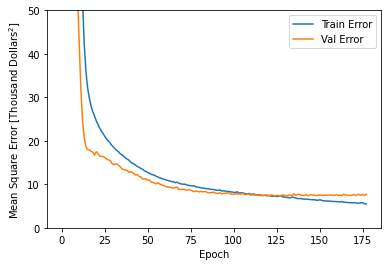

In [7]:
# Here and above you have a full example of a NN model performance plotting
# You should replicate this mechanism and apply it to other models as well (see TODO below)
def plot_history(hist=hist):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [Thousand Dollars$^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()
    plt.ylim([0,50])

plot_history()


### TODO: Make sure to have the same flow for CNN as well, as the goal will be to see 2 plots:
# each one contain train error and val error on each model (NN, CNN) respectively

Next, compare how the model performs on the test dataset:

In [8]:
test_features_norm = (test_features - train_mean) / train_std
mse, _, _ = model.evaluate(test_features_norm, test_labels)
rmse = np.sqrt(mse)
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

## TODO: Make sure to have a mechanism for CNN as well, as above

4/4 [==============================] - 0s 2ms/step - loss: 17.0342 - mae: 2.6761 - mse: 17.0342
Root Mean Square Error on test set: 4.127


In [9]:
# Conv1D
# model instantiation        
cnn_model = build_cnn_model()

# TODO: Read about EarlyStoppingRound!
early_stop_cnn = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# training the model and storing data into history
history_cnn = cnn_model.fit(train_features, train_labels, epochs=1000, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop_cnn, PrintDot()])

# using Pandas, generating data
hist_cnn_df = pd.DataFrame(history_cnn.history)
# Adding a column called epoch to that DataFrame
hist_cnn_df['epoch'] = history_cnn.epoch

# RMSE 
rmse_final = np.sqrt(float(hist_cnn_df['val_mse'].tail(1)))
print()
print('Final Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))


....................................................................................................
....................................................................................................
....................................................................................................
............
Final Mean Square Error on validation set: 2.45


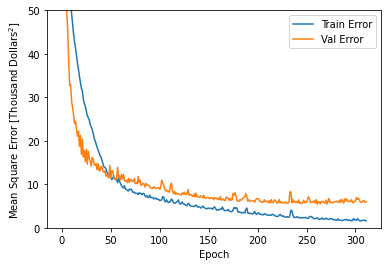

In [10]:
# Let's plot the history of our Conv1d CNN model over time
plot_history(hist=hist_cnn_df)

In [11]:
mse_cnn, _, _ = cnn_model.evaluate(test_features_norm, test_labels)
rmse_cnn = np.sqrt(mse_cnn)
print('Root Mean Square Error on test set: {}'.format(round(rmse_cnn, 3)))

4/4 [==============================] - 0s 3ms/step - loss: 12.3703 - mae: 2.3895 - mse: 12.3703
Root Mean Square Error on test set: 3.517


## Acknowledgements

The contents of this tutorial is based on and inspired by the work of [TensorFlow team](https://www.tensorflow.org) (see their [Colab notebooks](https://www.tensorflow.org/tutorials/)), our [MIT Human-Centered AI team](https://hcai.mit.edu), and individual pieces referenced in the [MIT Deep Learning](https://deeplearning.mit.edu) course slides.

### Done! You just finished a competition between NN and CNN, where both network knows how to predict house prices